In [1]:
#This code works with python 3.10.0
import sys
sys.version_info

sys.version_info(major=3, minor=10, micro=0, releaselevel='final', serial=0)

In [2]:
import alchemlyb
import alchemlyb.parsing.namd as parser
import numpy as np
import pandas as pd
from alchemlyb.estimators import MBAR,BAR
from alchemlyb.visualisation import plot_convergence
from alchemlyb.visualisation.dF_state import plot_dF_state
from alchemlyb.postprocessors.units import to_kcalmol, to_kJmol, to_kT
import warnings
import matplotlib.pyplot as plt
import seaborn as sns

warnings.filterwarnings("ignore")

Warning on use of the timeseries module: If the inherent timescales of the system are long compared to those being analyzed, this statistical inefficiency may be an underestimate.  The estimate presumes the use of many statistically independent samples.  Tests should be performed to assess whether this condition is satisfied.   Be cautious in the interpretation of the data.

********* JAX NOT FOUND *********
 PyMBAR can run faster with JAX  
 But will work fine without it   
Either install with pip or conda:
      pip install pybar[jax]     
               OR                
      conda install pymbar       
*********************************


In [10]:
# Define the timesteps - this is the label for the initial structure picked from the MD simulation of the WT
timesteps = [50,70,110,170]
#Define mutation
mutations = ["a26t"]
# Create a list to store df and u_fits values
df={}
ddf={}
# Select ligand (TMPP or DHF); mutation directory, and creation,annihilation for charge changing mutations (ann or cre)
# charge_change = 'cre'
ligand = 'tmpp'

In [11]:
for mutation in mutations:
    # Create a list to store the u_nk
    energies_list = []
    errorbars_list = []
    u_nks = []
    for timestep in timesteps:
        # Extract the u_nk values for the forward and backward simulations
        u_nk_fwd = parser.extract_u_nk(ligand+'/'+ligand+'_'+mutation+'_'+str(timestep)+'ns_fw.fepout',310)
        u_nk_rev = parser.extract_u_nk(ligand+'/'+ligand+'_'+mutation+'_'+str(timestep)+'ns_bw.fepout',310)
        # replace zeroes in initial dataframe with nan
        u_nk_fwd.replace(0, np.nan, inplace=True)
        # replace the nan values with the reverse dataframe --
        # this should not overwrite any of the fwd work values
        u_nk_fwd[u_nk_fwd.isnull()] = u_nk_rev
        # replace remaining nan values back to zero
        u_nk_fwd.replace(np.nan, 0, inplace=True)
        # sort final dataframe by `fep-lambda` (as opposed to `timestep`)

        u_nk = u_nk_fwd.sort_index(level=u_nk_fwd.index.names[1:])
        print(u_nk.shape)

       # Add the u_nk values to the list
        u_nks.append(u_nk)
        
    u_concat = alchemlyb.concat(u_nks)
    u_concat = u_concat.sort_index(level=u_concat.index.names[1:])
    print(u_concat.shape)


# u_nk picks the dE column from the fepout files, u_concat puts all sets together in a single matrix all in units of kT.

(1683, 33)
(1683, 33)
(1683, 33)
(1683, 33)
(6732, 33)


In [12]:
for mutation in mutations:
    
#CALCULATE BAR; uncertainties in BAR are problematic (adding bootstrapping needed)
    bar = BAR(relative_tolerance=1e-12).fit(u_concat)
    dF_bar_concat = to_kcalmol(bar.delta_f_)
    ddF_bar_concat = to_kcalmol(bar.d_delta_f_)
    energies_list.append(dF_bar_concat.loc[0.00, 1.00])
    errorbars_list.append(ddF_bar_concat.loc[0.00, 1.00])
    for sim in range(len(u_nks)):
        bar_ = BAR(relative_tolerance=1e-12).fit(u_nks[sim])
        dF_bar = to_kcalmol(bar_.delta_f_)
        ddF_bar = to_kcalmol(bar_.d_delta_f_)
        energies_list.append(dF_bar.loc[0.00, 1.00])
        errorbars_list.append(ddF_bar.loc[0.00, 1.00])
df[mutation] = energies_list
ddf[mutation] = errorbars_list
print(df[mutation])

# The first energy value is for the concatenated outputs; the rest are for the individual runs
with open('bar_energieskcalmol_'+mutation+'_'+ligand+'.dat', 'w') as f:
    f.write("Mutation\tBAR_concat\tBAR_individuals\n")
    f.write(mutation + '\t' + ' '.join(f"{x:.2f}" for x in df[mutation]) + '\n')

[-1.2777917038412656, -0.1634788859787247, -0.5234998930580423, -0.7897217736999105, -3.622102937579085]


column labels: Index([    0.0, 0.03125,  0.0625, 0.09375,   0.125, 0.15625,  0.1875, 0.21875,
          0.25, 0.28125,  0.3125, 0.34375,   0.375, 0.40625,  0.4375, 0.46875,
           0.5, 0.53125,  0.5625, 0.59375,   0.625, 0.65625,  0.6875, 0.71875,
          0.75, 0.78125,  0.8125, 0.84375,   0.875, 0.90625,  0.9375, 0.96875,
           1.0],
      dtype='object')


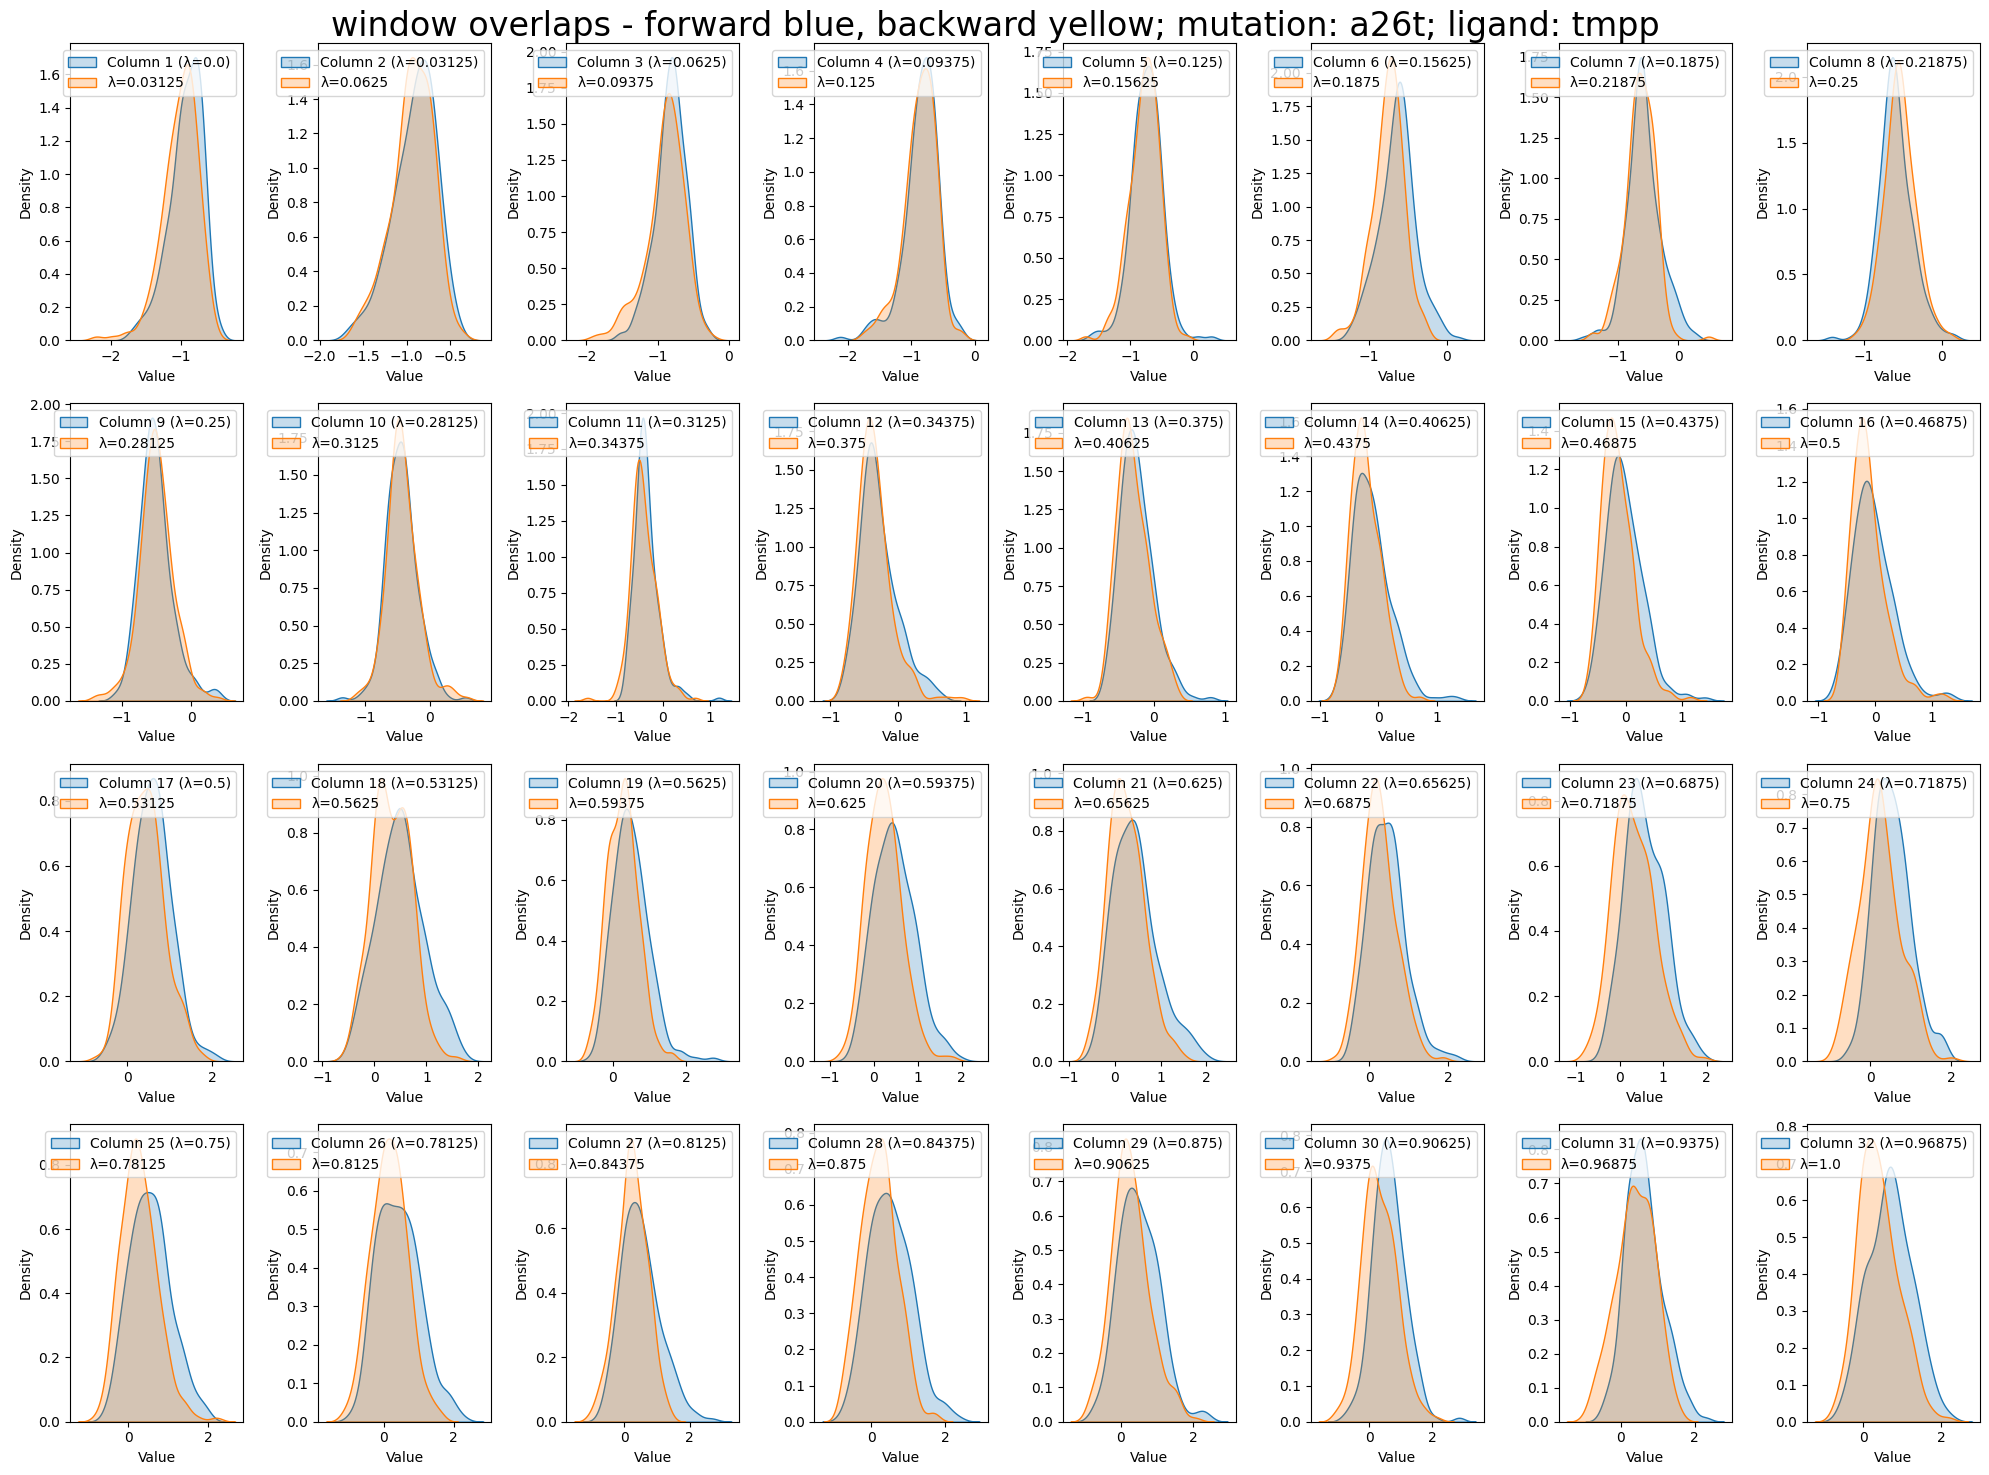

In [13]:
# Create a figure with a 4 by 8 matrix of subplots
fig, axes = plt.subplots(4, 8, figsize=(20, 15))
axes = axes.flatten()  # Flatten the axes array for easy iteration

# Initialize a counter for the subplot index
subplot_idx = 0

column_labels = u_concat.columns
print('column labels:',column_labels)
columns_no = column_labels.shape

# Iterate over the column labels
for i in range(0, columns_no[0]-1):
    # Get the label from the first row of the current column
    label1 = column_labels[i]
    label2 = column_labels[i+1]
#    print(u_concat.iloc[:, 0])

    set1 = u_concat.xs(label1, level=1)[label2]
    set2 = -u_concat.xs(label2, level=1)[label1]

    # Plotting the probability distributions on the respective subplot
    sns.kdeplot(set1, label=f'Column {i+1} (λ={label1})', shade=True, ax=axes[subplot_idx])
    sns.kdeplot(set2, label=f'λ={label2}', shade=True, ax=axes[subplot_idx])

    # Setting title and labels
#    axes[subplot_idx].set_title(f'Overlay λ={column_label} and λ={column_label - 1}')
    axes[subplot_idx].set_xlabel('Value')
    axes[subplot_idx].set_ylabel('Density')

    # Show the legend
    axes[subplot_idx].legend()

    # Move to the next subplot
    subplot_idx += 1

fig.suptitle(f'window overlaps - forward blue, backward yellow; mutation: {mutation}; ligand: {ligand}', fontsize=24)

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the final plot
plt.show()

filename = f'overlaps_{mutation}_{ligand}.png'
fig.savefig(filename, dpi=300, bbox_inches='tight')  # Save the plot with the variable in the file name

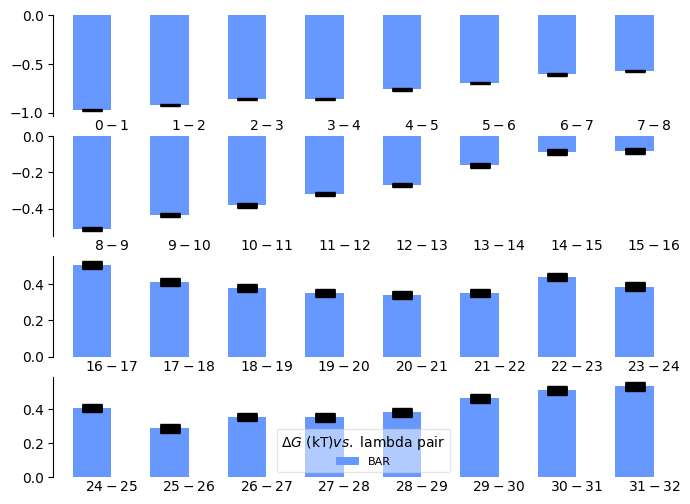

In [14]:
for mutation in mutations:
    plot_dF_state(bar)

(33, 33)
sum of squares: 0.004461042933231115 ; rmsd error: 0.06679103931839296 kcal/mol


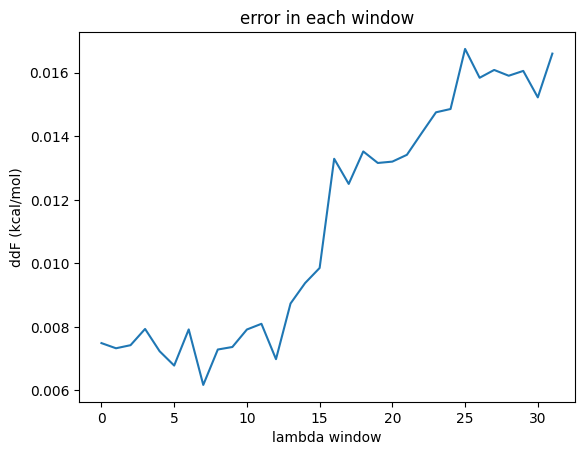

In [15]:
for mutation in mutations:
    a_list = []
    bsq = 0
    brmsd = 0
    a = ddF_bar_concat.to_numpy(dtype='float', na_value=np.nan)
    a.size
    type(a)
    print(a.shape)
        
    for i in range(len(a)):
        b = a[i][i-1]
        if i > 0:
    #        print(b)
            a_list.append(b)
            bsq += b*b
    brmsd = np.sqrt(bsq)
    print ('sum of squares:',bsq,'; rmsd error:',brmsd,'kcal/mol')
    plt.plot(a_list)
    plt.title('error in each window')
    plt.xlabel('lambda window')
    plt.ylabel('ddF (kcal/mol)')
    plt.show
 

In [16]:
# writing RMSD error
x = np.float(brmsd)
with open('bar_energieskcalmol_'+mutation+'_'+ligand+'.dat', 'a') as f:
    f.write('rmsd error: {:.3f}\n'.format(x))